In [49]:
import pandas as pd
import matplotlib.pyplot
# import thinkplot
import numpy as np
import re
# from tqdm import tqdm
# from reporter import Reporter
import random
import time
import pickle

Import the dictionary of ASIN IDs as keys to product titles as values:

In [32]:
file_name = "email-departments-12-05"
picklefile = open(file_name,'rb')
dep_map = pickle.load(picklefile)
print(dep_map['3'])

def get_department(id):
    return dep_map[id]

21


Import adjacency matrix saved as copurchases pickle file

In [18]:
# open the file for writing
file_name = "copurchases-emails-12-05"
picklefile = open(file_name,'rb')
copurchases = pickle.load(picklefile)

print(copurchases['3'])

['2', '4', '63', '174', '408', '58', '175', '114', '192', '303', '56', '286', '59', '236', '587', '281', '665', '520', '412', '195', '411', '137', '158', '194', '211', '239', '183', '272', '107', '571', '160', '599', '859', '89', '62', '812', '601', '886', '57', '102', '208', '6', '832', '371', '434', '256', '685', '481', '81', '193', '323', '55', '249', '971', '845', '271', '252', '138', '880', '932', '473', '405', '210', '46', '128', '283', '166', '990', '1001']


Class for Reporter object that stores cliques, and can print them

In [65]:
class Reporter(object):
    def __init__(self, name):
        self.name = name
        self.cnt = 0
        self.cliques = []

    def inc_count(self):
        self.cnt += 1

    def record(self, clique):
        self.cliques.append(clique)

    def sort_cliques(self):
        self.cliques.sort(key=len, reverse=True)

    def print_max(self, n):
        # print the n largest cliques
        self.sort_cliques()
        print(self.name)
        print('%d recursive calls' % self.cnt)
        for i in range(n):
            clique = self.cliques[i]
            products = []
            departments = []
            for el in clique:
                products.append(el)
                dep = get_department(el)
                departments.append(dep)
            print('Clique %d' % i)
            print('People IDs: %s' % (products))
            print('Department IDs: %s' % (departments))
        print()

    def print_report(self):
        print(self.name)
        print('%d recursive calls' % self.cnt)
        products = []
        departments = []
        for i, clique in enumerate(self.cliques):
            for element in clique:
                products.append() # TODO: append get_name(element)
                dep = get_department(element)
                departments.append(dep)
            print('Clique %d' % i)
            print('People IDs: %s' % (products))
            print('Department IDs: %s' % (departments))
        print()
        
    def get_cliques(self):
        self.sort_cliques()
        return self.cliques


### Implement naive Bron–Kerbosch algorithm

In [66]:
def bronKerbosch1(clique, candidates, excluded, reporter):
    '''Naive Bron–Kerbosch algorithm'''
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= 3:
            reporter.record(clique)
        return
    
    for v in list(candidates):
        new_candidates = candidates.intersection(copurchases[v])
        new_excluded = candidates.intersection(copurchases[v])
        bronKerbosch1(clique+[v], new_candidates, new_excluded, reporter)
        candidates.remove(v)
        excluded.add(v)

In [67]:
start = time.time()
report1 = Reporter('## %s' % bronKerbosch1.__doc__)
bronKerbosch1([], set(copurchases.keys()), set(), report1)
end = time.time()
print('Naive method: %f ms' % (end - start))

Naive method: 202.463359 ms


In [68]:
cliques = report1.get_cliques()

In [69]:
print(len([x for x in cliques if len(x) > 6]))

18708038


The size of the maximal clique is 18!

In [70]:
report1.print_max(10)

## Naive Bron–Kerbosch algorithm
37490038 recursive calls
Clique 0
People IDs: ['87', '183', '128', '28', '106', '62', '107', '21', '212', '256', '303', '129', '114', '371', '81', '434', '405', '249']
Department IDs: ['34', '4', '5', '11', '38', '36', '36', '9', '34', '4', '20', '4', '10', '16', '15', '34', '38', '14']
Clique 1
People IDs: ['87', '183', '128', '28', '106', '62', '107', '21', '212', '303', '129', '329', '114', '371', '81', '434', '405', '249']
Department IDs: ['34', '4', '5', '11', '38', '36', '36', '9', '34', '20', '4', '8', '10', '16', '15', '34', '38', '14']
Clique 2
People IDs: ['87', '183', '128', '28', '106', '62', '21', '212', '256', '303', '365', '129', '114', '371', '81', '434', '405', '249']
Department IDs: ['34', '4', '5', '11', '38', '36', '9', '34', '4', '20', '14', '4', '10', '16', '15', '34', '38', '14']
Clique 3
People IDs: ['87', '183', '128', '28', '106', '62', '21', '212', '303', '365', '129', '329', '114', '371', '81', '434', '405', '249']
Department

### Visualize a clique breakdown by department as a pie chart 

The numbers labelling the wedges are the department ID numbers. Since there are many departments represented in the maximum cliques, we hypothesize that the EU Research institution where this network of emails came from has many interdisciplinary teams.

Pie chart of department distribution of Cliques


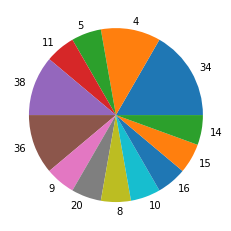

In [62]:
num = 1 # Change this to change which clique you are visualizing

report1.sort_cliques()
cliques = report1.get_cliques()[num]

products = []
departments = {}
for el in cliques:
    products.append(el)
    dep = get_department(el)
    if dep in departments:
        departments[dep] += 1
    else:
        departments[dep] = 1

matplotlib.pyplot.pie(departments.values(), labels=departments.keys())

print("Pie chart of department distribution of Cliques")

### Implement Bron-Kerbosch Algorithm with a Pivot

Implement Bron–Kerbosch algorithm with a pivot. Randomly pick a vertex u from `candidates` or `excluded`. The maximal clique must include either u or one of its non-neighbors.

In [72]:
def bronKerbosch2(clique, candidates, excluded, reporter):
    '''Bron–Kerbosch algorithm with pivot'''
    reporter.inc_count()
    if not candidates and not excluded:
        if len(clique) >= 3:
            reporter.record(clique)
        return
    u = pick_pivot(candidates) or pick_pivot(excluded)
    # only consider u or its non neighbors
    for v in list(candidates.difference(copurchases[u])):
        new_candidates = candidates.intersection(copurchases[v])
        new_excluded = candidates.intersection(copurchases[v])
        bronKerbosch2(clique+[v], new_candidates, new_excluded, reporter)
        candidates.remove(v)
        excluded.add(v)
        
def pick_pivot(nodes):
    if nodes:
        return random.sample(nodes, 1)[0]

In [73]:
start = time.time()
report2 = Reporter('## %s' % bronKerbosch2.__doc__)
bronKerbosch2([], set(copurchases.keys()), set(), report2)
end = time.time()
print('Pivot method:', end - start)

Pivot method: 29.357981204986572


In [74]:
report2.print_max(10)

## Bron–Kerbosch algorithm with pivot
1809875 recursive calls
Clique 0
People IDs: ['87', '183', '106', '303', '28', '107', '129', '405', '62', '256', '249', '371', '81', '21', '114', '434', '212', '128']
Department IDs: ['34', '4', '38', '20', '11', '36', '4', '38', '36', '4', '14', '16', '15', '9', '10', '34', '34', '5']
Clique 1
People IDs: ['87', '183', '106', '303', '28', '107', '129', '405', '62', '329', '81', '249', '371', '114', '128', '434', '21', '212']
Department IDs: ['34', '4', '38', '20', '11', '36', '4', '38', '36', '8', '15', '14', '16', '10', '5', '34', '9', '34']
Clique 2
People IDs: ['87', '183', '106', '303', '28', '365', '212', '128', '114', '405', '81', '434', '62', '256', '371', '249', '129', '21']
Department IDs: ['34', '4', '38', '20', '11', '14', '34', '5', '10', '38', '15', '34', '36', '4', '16', '14', '4', '9']
Clique 3
People IDs: ['87', '183', '106', '303', '28', '365', '212', '128', '114', '405', '81', '434', '62', '329', '249', '371', '129', '21']
Depart